# MuchLearningSuchWow - LSTM - Training

This notebook contains the code we used to define and train our LSTM network. The training code is based loosely on [this kernel](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7).

### Imports & Data Paths

In [1]:
import numpy as np
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D
from keras.utils import plot_model
from keras.optimizers import Adam

import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
inputPath = "input/m5-forecasting-accuracy/"
outputPath = "output/"
modelPath = "models/"

### Constants

In [3]:
timesteps = 14 # Number of previous days that will be used to predict the next day
startDay = 1000 # Number of days at start of data that will be ignored during training

### Loading Data

In [4]:
with open(outputPath + "/preprocessed_train_valid_data.pkl", "rb") as f:
    df_train_valid = pickle.load(f)
with open(outputPath + "/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [5]:
df_train = df_train_valid[:-28] # Remove validation data (the Kaggle validation data, not the part we set aside ourselves)
print(df_train.shape)

(913, 30504)


In [6]:
df_train_scaled = scaler.transform(df_train) # Scale the training data

### Create Training/Validation Data and Labels

In [7]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(df_train_scaled[i-timesteps:i])
    y_train.append(df_train_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels

In [8]:
del df_train_scaled

In [9]:
# Convert data to np array to be able to feed it to the model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(899, 14, 30504)
(899, 30490)


### LSTM Model

In [10]:
model = Sequential()

# 1D convolution layer
model.add(Conv1D(filters=32, kernel_size=7, strides=1, padding="causal", 
                 activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))

# LSTM layers
layer_1_units=150
model.add(LSTM(units = layer_1_units, return_sequences = True))
model.add(Dropout(0.3))

layer_2_units=150
model.add(LSTM(units = layer_2_units, return_sequences = True))
model.add(Dropout(0.3))

layer_3_units=400
model.add(LSTM(units = layer_3_units))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units = 30490))

In [11]:
plot_model(model, modelPath + "/model.png")
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            6832928   
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 150)           109800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 150)           180600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 150)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               881600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)              

### Training

In [12]:
# Define the loss function (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile the model
model.compile(optimizer = Adam(learning_rate=0.001), loss = root_mean_squared_error)

# Fit the model to the training set
nr_epochs = 25
batch_size = 32
history = model.fit(X_train, y_train, 
                    epochs = nr_epochs, 
                    batch_size = batch_size, 
                    verbose = 1)

Epoch 1/25
899/899 [==============================] - 24s 26ms/step - loss: 0.1512
Epoch 2/25
899/899 [==============================] - 23s 26ms/step - loss: 0.1430
Epoch 3/25
899/899 [==============================] - 26s 29ms/step - loss: 0.1416
Epoch 4/25
899/899 [==============================] - 27s 30ms/step - loss: 0.1408
Epoch 5/25
899/899 [==============================] - 26s 29ms/step - loss: 0.1396
Epoch 6/25
899/899 [==============================] - 25s 28ms/step - loss: 0.1383
Epoch 7/25
899/899 [==============================] - 24s 27ms/step - loss: 0.1376
Epoch 8/25
899/899 [==============================] - 24s 27ms/step - loss: 0.1370
Epoch 9/25
899/899 [==============================] - 24s 27ms/step - loss: 0.1364
Epoch 10/25
899/899 [==============================] - 25s 28ms/step - loss: 0.1359
Epoch 11/25
899/899 [==============================] - 25s 27ms/step - loss: 0.1357
Epoch 12/25
899/899 [==============================] - 25s 27ms/step - loss: 0.1352
E

### Saving Result

In [13]:
model.save(modelPath + "/lstm_model_final")

### Plotting Losses

In [14]:
def plot_loss(history, nr_epochs, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(1, nr_epochs+1), history.history['loss'], label='train_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

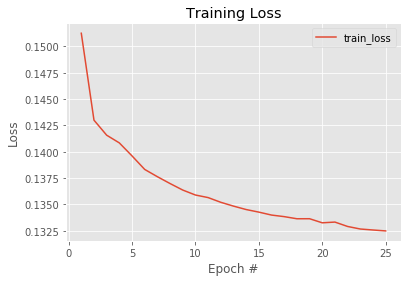

In [15]:
plot_loss(history, nr_epochs, 'Training Loss')